## Two-Sided Marketplace Economics in Pytorch

**Motivating example:** Consider a platform that connects pet owners with pet-care service providers. The platform charges fees of 5% to pet owners while it charges 25% to service providers. For any given transaction price, say $20 for a dog walk, the buyer spends ($20 + $1) = $21 net, while the service provider receives ($20 - $5) = $15 net. The platform earns $1+$5 = $6  (i.e. 30% of $20). Will the platform's revenue be the same with other fee-combinations that still add up to the same 30% (e.g. 15% to each side)? Of course not, as the new fee structure will alter the willingness to use the service. In two-sided markets, changes in the price struture can lead to large changes in user participation, transaction volume and profitability. In some cases, it is beneficial to subsidize one side of the market by pricing the service below the platform's cost (and making it up on the other side of the market).

**Summary:** I implement pricing models for *two-sided platforms*  using Pytorch. Two-sided marketplaces show up in a wide variety of sectors including homestays (e.g. Airbnb), ridesharing (e.g. Lyft), payment systems (e.g. Apple pay), and app-stores (e.g. for Apple, Android, Amazon). Deep learning frameworks like Pytorch (and TensorFlow) provide *automatic gradient calculation*. This makes it easy to implement analytical models without worrying (too much) about calculating analytical gradients for experimental functional forms. Customized gradients can also be implemented as needed. Quantitative adaptations of analytical models can then be integrated with  user-behavior analytics running on the same machine learning infrastructure.

### Features of two-sided marketplaces: 
Econ 101 based pricing models are not directly applicable in two-sided marketplaces as some features complicate the analysis.

#### 1. Two-sided network effects
An instance of *one-sided* network effects arises in pure messenger applications (e.g. WhatsApp or Snapchat) where users' value for the service depends primarily on the number of *peers* connected to the service. Two-sided network effects arise from having more participants on the other side of the platform. In marketplaces, the two sides are typically service demanders (e.g. pet owners) and service suppliers (e.g. pet-care service providers).

Many *social networks* have both one-sided and two-sided (*cross platform*) network effects as they also serve as advertising platforms, media distribution channels, professional recruitment channels, or provide payment services.

#### 2. Price structure optimization
Price structure optimization (ratio of prices charged to each side) is a key feature of two-sided marketplaces. If the volume of transactions on the platform depends  *only on the sum* of fees charged to both sides, then the platform is still one sided and does not require different pricing models.

### Preliminaries
 
A platform connects two sides: buyers (B) and sellers (S). There are no direct payments between buyers and sellers so all monetary transfers are through the platform. For instance, in the case of media platforms such as newspapers (e.g. WSJ or NY Times), subscribers as well as advertisers pay the platform. In payment services (e.g. Amex), users pay their payment service provider (or bank) who eventually compensates sellers.

Start with some initial parameterization. There are $N_{B}$ potential buyers and $N_{S}$ potential sellers. Only some fraction $\theta_{i}$ all potential users join the platform. Thus we have actual number of buyers as $n_{B}=\theta_{B}N_{B}$ and the actual number of sellers on the platform as $n_{S}=\theta_{S}N_{S}$.

### Demand and inverse demand functions
I adopt a discrete choice (random utility) approach. The net utility for a user on side $i$ has a fixed component and a variable one that depends on the number of participants $n_{j}$ on the other side. This is expressed by the relationship 
$$
U_{i} = B_{i} + (b_{i} - p_{i})X_{i}(n_{j}) + \epsilon_{i}
$$
$B_{i}$ is a user's "fixed benefit" from simply joining the platform (pure membership benefit even with zero transactions). This may be zero. And in some cases, $B$ may even be negative, e.g. when app developers must spend their own resources to develop the product for a platform, even if no one buys their application.

$b_{i}$ is user $i$'s benefit per each transaction on the platform, $p_{i}$ is the per-transaction fee charged by the platform. The function $X_{i}(n_{j})$ determines the nature of the **network effect** of the number of participants   $n_{j}$ on the other side.

$\epsilon_{i}$ denotes a zero-mean random variable (just as in any discrete choice model). We do not make use of it in the current analysis (treat it as zero). It appears here simply as a reminder that we will have to make assumptions about it when integrating the pricing model with data analytics, product promotions etc.

For a user to participate in the marketplace, their expected utility must be positive. Let  $H_{i}(U_{i}) \equiv prob\{U_{i}\ge 0\}$ denote a function for the corresponding *choice probability*. Then, the expected participation level is given by the product of the choice probability with the number of potential users of the same type.
\begin{align}
&n_{i} = H_{i}(U_{i})*N_{i}\\
&n_{i}(p_{i}, n_{j}) = H_{i}(B_{i} + (b_{i} - p_{i})X_{i}(n_{j})) * N_{i}
\end{align}

If we know the functions $H()$ and $X()$, then we can jointly solve the system $n_{B}(p_{B},n_{S})$ (for buyers) and $n_{S}(p_{S}, n_{B})$ (for sellers) to obtain **demand functions** that depend on prices charged to both sides as $n_{B}(p_{B},p_{S})$ and  $n_{S}(p_{B},p_{S})$. 

In general, these will be fixed points that solve equations of the form
$$
n_{i}(p_{i},p_{j}) = H_{i}\left(B_{i} + (b_{i}-p_{i})X_{i}\left(H_{j}\left(B_{j} + (b_{j}-p_{j})X_{j}(n_{i}(p_{i},p_{j})) \right)*N_{j} \right) \right)*N_{i}
$$

These demand functions can then be used to set prices to optimize profit.

However, as illustrated below, in practice, it is often easier to isolate the prices rather than the participation levels. In other words, we derive **inverse demand functions** $p_{B}(n_{B},n_{S})$ and $p_{B}(n_{B},n_{S})$ and use those for optimization.

In [1]:
import torch

##potential number of buyers and sellers (not all will join platform), normalized to measure 1
N_B, N_S = torch.tensor([1.,1.]) 

#initial fraction of actual users (not in RT)
theta_B, theta_S = torch.tensor([.5,.5])  

#Actual participants. These will be the control variables in the optimization, gradients will be tracked.
n_B = torch.tensor(theta_B * N_B, requires_grad=True) #track gradients
n_S = torch.tensor(theta_S * N_S, requires_grad=True) #track gradients

#Platform's cost per transaction of providing the service to users (variable costs only, no fixed costs)
c_B, c_S = torch.tensor([.0,.0]) #RT used a single combined cost

#User benefit (fixed, pure membership benefit)
B_B, B_S = torch.tensor([.0,.0]) #in some cases, these may be negative for sellers, i.e. cost of providing the service

#User benefit (per transaction)
b_B, b_S = torch.tensor([7.5,7.5]) #in some cases, these may be negative for sellers, i.e. cost of providing the service

#initialize platform prices or fees: (Not really needed)
p_B, p_S = torch.tensor([.1,.1])

Unlike RT, we will be optimizing over the platform's choice of user participation levels $n_B$ and $n_S$, and not directly over prices $p_{B}$ or $p_{S}$. This is why we are "tracking" gradients for the $n$'s rather than prices $p$'s. We compute prices as functions of participation levels as will be clear below.



**Functional specification:** Rochet and Tirole assume a linear formulation for the externality effect $X(n)=n$. Furthermore their theoretical analysis does not rely on any specific formulation for the choice probability $H()$. To implement the model in Pytorch, I experiment with *sigmoid* or *hyperbolic tangent* formulations for $X()$ and $H()$. 
For the network effect $X( )$ in particular, the sigmoid and tanh( ) functions allow us to abstract the idea that network effects grow slowly at first as some initial users join a platform. Once a **critical mass** is reached, network effects grow rapidly, which is why platform operators must spend heavily to acquire users. However, after a point there is some **saturation** and network effects get muted (i.e. *diminishing returns* from further increases in membership).

#### Inverse demand illustration with sigmoid choice and tanh network effect
Suppose we assume the following specifications for $H()$ and $X()$
$$
H(U_{i}) = \frac{\exp(U_{i})}{1+\exp(U_{i})} \mbox{ and } X(n_{j}) = 1 + tanh(n_{j}-k_{i}.N_{j})
$$
where $k_{i}>0$ (note $i$, and not $j$) shifts the distribution (of tanh( ) ) to the right and acts as a saturation point for users of type $i$ as they think about the adoption rate by users of type $j$. For instance, $k$ will be large for payment networks where fairly high adoption rates are required (at least by sellers). 

Then the participation level on the buyers' side is given by
$$
n_{B} = H(U_{B}) * N_{B}, \mbox{ where } U_{B} = B_{B} + (b_{B}-p_{B})(1+\tanh(n_{S}-k_{B}N_{S}))
$$
Note that we have a similar expression for $n_{S}$ as a function of $n_{B}$, so it is hard to explicitly solve for  $n_{B}$ above.

Instead, we can try to *isolate the price* as a function of participation levels (on both sides).
$$
p_{B}(n_{B},n_{S}) = b_{B} - \frac{1}{1+ tanh(n_{S}-k_{B}N_{S})}\left[\ln\left(\frac{n_{B}}{N_{B}-n_{B}} \right) -B_{B}\right]\ (Eq.1)
$$
this is the inverse demand function on the buyers' side to join the platform.

Similarly, we obtain the inverse demand for the sellers' (to join the platform) as
$$
p_{S}(n_{B},n_{S}) = b_{S} - \frac{1}{1 + tanh(n_{B}-k_{S}N_{B})}\left[\ln\left(\frac{n_{S}}{N_{S}-n_{S}} \right)-B_{S}\right]\ (Eq.2)
$$

### Profit optimization
The volume of transactions on a platform depends on the specifics of each product market category, time horizons etc. One simple metric for the number of potential interactions is just the product $n_{B}n_{S}$. This leads to an expression for expected profit of the form

$$
\max_{n_{B},\  n_{S}} \ \mbox{profit} = \max_{n_{B},\  n_{S}} \  n_{B}n_{S}\times [p_{B}(n_{B},\  n_{S})-c_{B} + p_{S}(n_{B},\  n_{S}) - c_{S}] \ (Eq.3)
$$
where $c_{B}$ and $c_{S}$ are the platform's per interaction costs for facilitating each transaction for buyers and sellers respectively.

In [4]:
lr = 0.01 #learning rate
#update prices to optimize profit
print('i','nb','ns','pb','ps','profit')
for i in range(10):
    #inverse demand for sellers
    net_ext_B2S = (1 + torch.tanh(n_B - .25*N_B))#diminishing returns after 25 percent of potential users
    p_S = b_S - (1/net_ext_B2S) * (torch.log(n_S/(N_S - n_S)) - B_S)
    #notes: obviously n<1. But we also need n>N/2, else log(n/N-n) < 0 => p > b!
    #The N/2 comes from the logistic (binomial) formulation. Other distributions will have different bounds.
    #an alternative is to use 2*sigmoid -1 instead.
    
    #similarly for buyers (inverse demand on the buyers side)
    net_ext_S2B = (1 + torch.tanh(n_S - .75*N_S)) #diminishing returns after 75 adoption rate
    p_B = b_B - (1/net_ext_S2B) * (torch.log(n_B/(N_B - n_B)) - B_B)
    
    #platform profit: number of interactions (nB*NB*nS*NS) times margin from each
    profit = n_B * n_S* (p_S - c_S + p_B - c_B)
    print(i, n_B.item(), n_S.item(),p_B.item(), p_S.item(), profit.item())    
    #compute the gradients
    profit.backward()
    #update the variables
    with torch.no_grad():
        n_B += lr*n_B.grad
        n_B.grad.zero_()
        n_S += lr*n_S.grad
        n_S.grad.zero_()



i nb ns pb ps profit
0 0.5617563724517822 0.5669673681259155 7.1968278884887695 7.293025016784668 4.614982604980469
1 0.6285724639892578 0.6395421028137207 6.908872127532959 7.078853607177734 5.623045444488525
2 0.6997640132904053 0.717294454574585 6.625226020812988 6.845095634460449 6.761250972747803
3 0.7735883593559265 0.7986789345741272 6.328306674957275 6.569171905517578 7.968690872192383
4 0.8459464311599731 0.8793843984603882 5.991003036499023 6.205080032348633 9.072813987731934
5 0.9071087837219238 0.9466218948364258 5.591631889343262 5.6759490966796875 9.675348281860352
6 0.9350646734237671 0.9542366862297058 5.279983997344971 5.595419406890869 9.703828811645508
7 0.923414945602417 0.943626880645752 5.410017490386963 5.724735260009766 9.70236873626709
8 0.9314384460449219 0.9579735398292542 5.334902763366699 5.5366644859313965 9.700627326965332
9 0.9267733693122864 0.9354175329208374 5.355063438415527 5.818220615386963 9.686344146728516


Rewrite the above as a function, with the parameters fed in so we can experiment with it. We have also replace the finite loop with one based on a tolerance level. In the version below, I replace $H()$ by 2\*sigmoid-1 rather than the plain sigmoid, so that it maps from 0 to 1 instead of from 1/2 to 1. The base sigmoid version is commented out.

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np


def adopt(
			N_B = torch.tensor([1.]), #exogenous no. of potential buyers
			N_S = torch.tensor([1.]), #exog number of potential sellers
			theta_B=torch.tensor([.25]), theta_S = torch.tensor([.25]), #Exog not interesting
			c_B = torch.tensor([.0]),c_S = torch.tensor([.0]), #Exog platform's cost per transaction
			b_B= torch.tensor([7.5]), b_S = torch.tensor([7.5]), #Exog benefit per transaction
			B_B= torch.tensor([0.]), B_S = torch.tensor([0.]), #Exog  fixed membership benefit  
			k_S = .25, k_B = .75 #critical value for participation rate where network effect exhibits diminishing returns
			):
	"""
	returns platform  adoption rates and prices for buyers and sellers
	"""
	
	n_B = torch.tensor(theta_B * N_B, requires_grad=True)
	n_S = torch.tensor(theta_S * N_S, requires_grad=True)
	
	tol = .005
	delta = 1
	lr = 0.001 #learning rate
	#print('\n\n')
	#for i in range(25):		
	while delta > tol:
		#rewriting above as inverse demand
		net_ext_B2S = (1+ torch.tanh(n_B - k_S*N_B)) #diminishing returns after 75 percent of potential users
		#p_S = b_S - (1/net_ext_B2S) * (torch.log(n_S/(N_S - n_S))- B_S) 
		p_S = b_S - (1/net_ext_B2S) * (torch.log((1 + n_S/N_S)/(1 - n_S/N_S)) - B_S)
		#similarly for buyers (inverse demand on the buyers side)
		net_ext_S2B = (1+ torch.tanh(n_S - k_B*N_S))
		#p_B = b_B - (1/net_ext_S2B) * (torch.log(n_B/(N_B - n_B)) - B_B)
		p_B = b_B - (1/net_ext_S2B) * (torch.log((1 + n_B/N_B)/(1 - n_B/N_B) ) - B_B)
		#platform profit: number of interactions (nB*NB*nS*NS) times margin from each
		profit = n_B * n_S* (p_S - c_S + p_B - c_B) #neglecting N_B * N_S has no impact
		#print(n_B.item(), n_S.item() )
		profit.backward()
		with torch.no_grad():
			delta = max(abs(lr*n_B.grad.item()/n_B.item()),abs(lr*n_S.grad.item()//n_S.item()))
			n_B += lr*n_B.grad
			n_B.grad.zero_()
			n_S += lr*n_S.grad
			n_S.grad.zero_()

	return n_B, n_S, p_B, p_S

### Numerical illustrations
 The following plots illustrate the impact of increasing the base of potential users. For illustration, I only vary the number of potential participants on the seller's side $N_{S}$, while keeping the number of potential buyers constant at one $N_{B}=1$. 

Text(0,0.5,'price')

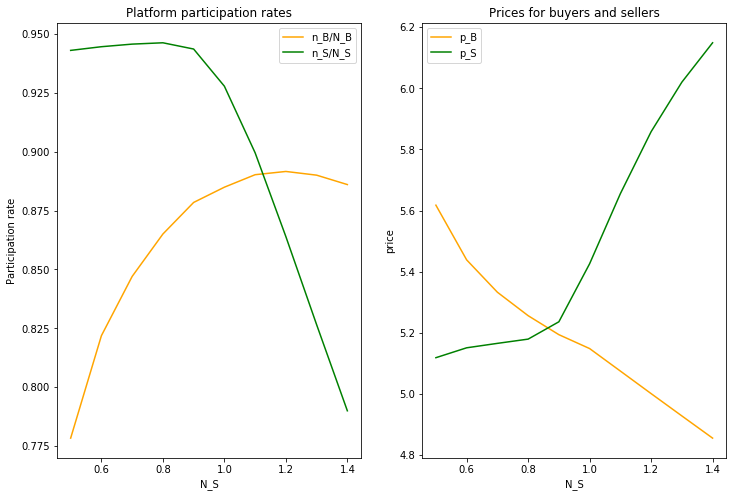

In [14]:
%matplotlib inline
"""
The impact of increasing (potential participants) on one side of the market (more potential sellers).
"""

N_B=torch.tensor([1.])
N_S = torch.arange(.5,1.5,.1)
len = N_S.size()[0]
n_B, n_S, p_B, p_S = torch.empty([len]), torch.empty([len]),torch.empty([len]),torch.empty([len])
for i in range(len):
	n_B[i], n_S[i],p_B[i],p_S[i] = adopt(N_B = N_B, N_S = N_S[i])
	
f,(ax1,ax2) = plt.subplots(1,2,sharey=False, sharex=False, figsize=(12,8))
ax1.plot(N_S.numpy(), n_B.detach().numpy()/N_B.numpy(), 'orange', label='n_B/N_B') #detach() grad-required variable to
ax1.plot(N_S.numpy(), n_S.detach().numpy()/N_S.numpy(), 'g', label='n_S/N_S')
ax1.legend()
ax1.set_title('Platform participation rates')
ax1.set_xlabel('N_S')
ax1.set_ylabel('Participation rate')
ax2.plot(N_S.numpy(), p_B.detach().numpy(), 'orange', label='p_B')
ax2.plot(N_S.numpy(), p_S.detach().numpy(), 'g', label='p_S')
ax2.legend()
ax2.set_xlabel('N_S')
ax2.set_title('Prices for buyers and sellers')
ax2.set_ylabel('price')

The plot on the right shows the impact on the prices ($p_{S}, p_{B}$). An influx of sellers leads the platform to extract higher prices from them and lower prices from the relatively scarce buyers. This is fairly straightforward.
 
The impact of an increase in the number of sellers on actual participation rates is more profound. As the number of potential sellers increases, the participation rate of buyers increases at first, but then declines. This odd result can be attributed to the fact that we are looking at the platform's optimization, not that of individual buyers.

### Redundancies and extensions
There are some redundancies in the current formulation. It is straightforward to verify that all combinations of parameters $(b_{B}-c_{B}) + (b_{S}- c_{S}) = v$, for some constant $v$  lead to the same optimal solution in terms of the marketplace participation rates $n_{B}$ and $n_{S}$. Incidentally, $v$ can be interpreted as the per transaction value created by the platform (difference between users' valuations and platform's costs).

While participation rates are uniquely determined for each $v$, the redundancy implies that prices are not unique (for a given $v$). Of course, given specific values for the parameters we do obtain *nominally unique* prices $p_{B}$ and $p_{S}$ from (Eq.1) and (Eq.2). However, we should keep in mind that, in some cases, a price charged to one side of the market may be higher than the platform's cost ( $p_{i} < c_{i}$ is possible). This would be a situation of one side subsidizing the other, and is an issue of interest for the future extensions. 

Also of interest in future extensions is explicit calculations for price elasticities of demand for either side of the platform, as well as across the platform (i.e. how the price on one side indirectly influences participation on the other). This can also be useful for estimating the impact of promotins and other marketing experiments. 

Eventually we must account for heterogeneity in buyers and sellers, and also across markets, which will bring us a step closer in integrating this model with demand estimation and analytics. 

### References
1.  Jean-Charles Rochet and Jean Tirole, "Two-Sided Markets: A Progress Report," *Rand Journal of Economics*, 2006.
2.  Glen Weyl, "A Price Theory of Multi-Sided Platforms," *American Economic Review*, 2010.